### Data preparation

In [1]:
!pip install openimages

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 225.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip uninstall -y opencv-python
!pip install opencv-python-headless

Found existing installation: opencv-python 4.7.0.72
Uninstalling opencv-python-4.7.0.72:
  Successfully uninstalled opencv-python-4.7.0.72

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:
!oi_download_dataset --base_dir download --csv_dir download --labels Bottle Hat Shirt --format darknet --limit 3000

2023-03-09  23:41:24 INFO Downloading 3000 train images for class 'bottle'
100%|██████████████████████████████████████| 3000/3000 [00:28<00:00, 104.40it/s]
2023-03-09  23:41:53 INFO Creating 3000 train annotations (darknet) for class 'bottle'
100%|█████████████████████████████████████| 3000/3000 [00:00<00:00, 4600.50it/s]
2023-03-09  23:41:56 INFO Downloading 3000 train images for class 'hat'
100%|██████████████████████████████████████| 3000/3000 [00:28<00:00, 104.05it/s]
2023-03-09  23:42:24 INFO Creating 3000 train annotations (darknet) for class 'hat'
100%|█████████████████████████████████████| 3000/3000 [00:00<00:00, 4495.10it/s]
2023-03-09  23:42:27 INFO Downloading 430 train images for class 'shirt'
100%|█████████████████████████████████████████| 430/430 [00:04<00:00, 89.89it/s]
2023-03-09  23:42:32 INFO Creating 430 train annotations (darknet) for class 'shirt'
100%|███████████████████████████████████████| 430/430 [00:00<00:00, 3938.39it/s]


Example image

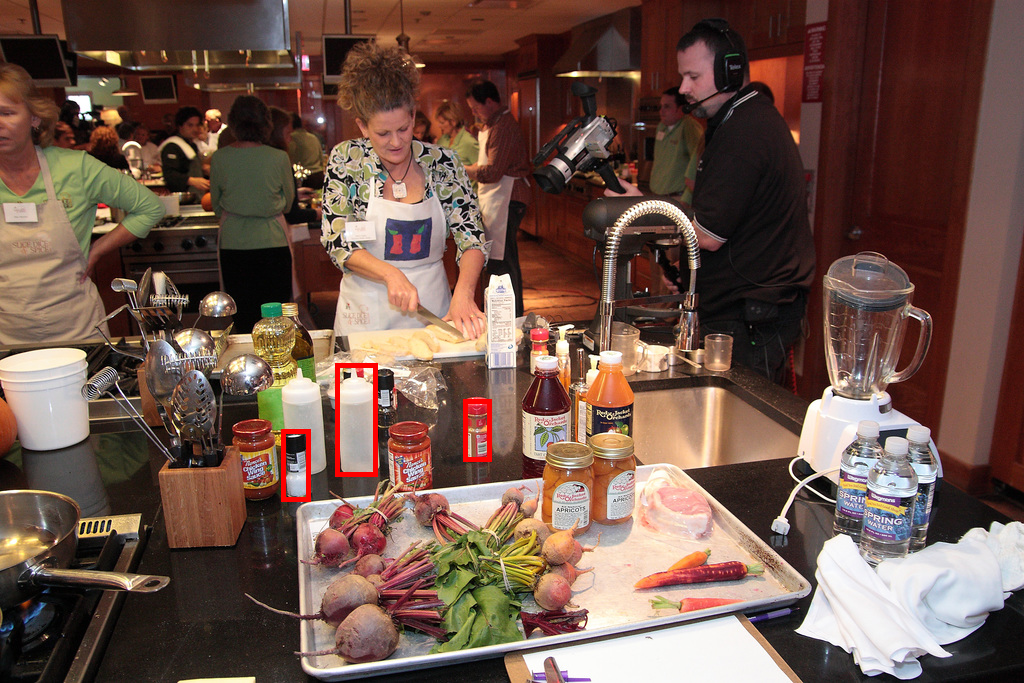

In [7]:
from PIL import Image, ImageDraw

def show_bbox(image_path):
    # convert image path to label path
    label_path = image_path.replace('/images/', '/darknet/')
    label_path = label_path.replace('.jpg', '.txt')

    # Open the image and create ImageDraw object for drawing
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    with open(label_path, 'r') as f:
        for line in f.readlines():
            # Split the line into five values
            label, x, y, w, h = line.split(' ')

            # Convert string into float
            x = float(x)
            y = float(y)
            w = float(w)
            h = float(h)

            # Convert center position, width, height into
            # top-left and bottom-right coordinates
            W, H = image.size
            x1 = (x - w/2) * W
            y1 = (y - h/2) * H
            x2 = (x + w/2) * W
            y2 = (y + h/2) * H

            # Draw the bounding box with red lines
            draw.rectangle((x1, y1, x2, y2),
                           outline=(255, 0, 0), # Red in RGB
                           width=5)             # Line width
    image.show()
    

show_bbox('download/bottle/images/0009d6b2e2f0c698.jpg')

Create folder structure

In [30]:
import os

# Create a folder structure for YOLOv5 training
if not os.path.exists('data'):
    for folder in ['images', 'labels']:
        for split in ['train', 'val', 'test']:
            os.makedirs(f'data/{folder}/{split}')

Check duplicates

In [23]:
import glob

def get_filenames(folder):
    filenames = set()

    for path in glob.glob(os.path.join(folder, '*.jpg')):
        # Extract the filename
        filename = os.path.split(path)[-1]
        filenames.add(filename)

    return filenames


# Dog and cat image filename sets
bottle_images = get_filenames('download/bottle/images')
hat_images = get_filenames('download/hat/images')
shirt_images = get_filenames('download/shirt/images')

In [24]:
# Check for duplicates
duplicates1 = bottle_images & hat_images
duplicates2 = bottle_images & shirt_images
duplicates3 = shirt_images & hat_images

print(duplicates1)
print(duplicates2)
print(duplicates3)

{'117c4a2c6d0c9a62.jpg'}
set()
{'6996d0e278641502.jpg'}


In [25]:
hat_images -= duplicates1

In [26]:
hat_images -= duplicates3

In [27]:
print(len(hat_images))

2998


Split images

In [28]:
import numpy as np

bottle_images = np.array(list(bottle_images))
hat_images = np.array(list(hat_images))
shirt_images = np.array(list(shirt_images))

# Use the same random seed for reproducability
np.random.seed(42)
np.random.shuffle(bottle_images)
np.random.shuffle(hat_images)
np.random.shuffle(shirt_images)

In [31]:
import shutil


def split_dataset(item, image_names, train_size, val_size):
    for i, image_name in enumerate(image_names):
        # Label filename
        label_name = image_name.replace('.jpg', '.txt')

        # Split into train, val, or test
        if i < train_size:
            split = 'train'
        elif i < train_size + val_size:
            split = 'val'
        else:
            split = 'test'

        # Source paths
        source_image_path = f'download/{item}/images/{image_name}'
        source_label_path = f'download/{item}/darknet/{label_name}'

        # Destination paths
        target_image_folder = f'data/images/{split}'
        target_label_folder = f'data/labels/{split}'

        # Copy files
        shutil.copy(source_image_path, target_image_folder)
        shutil.copy(source_label_path, target_label_folder)

# Bottle data
split_dataset('bottle', bottle_images, train_size=2250, val_size=375)

# Hay data (reduce the number by 1 for each set due to two duplicates)
split_dataset('hat', hat_images, train_size=2250, val_size=375)

# Hay data (reduce the number by 1 for each set due to two duplicates)
split_dataset('shirt', shirt_images, train_size=2249, val_size=374)

### YOLO

In [32]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15300, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15300 (delta 4), reused 2 (delta 0), pack-reused 15287
Receiving objects: 100% (15300/15300), 14.20 MiB | 37.28 MiB/s, done.
Resolving deltas: 100% (10487/10487), done.


In [33]:
! sed -i 's/opencv-python/opencv-python-headless/' yolov5/requirements.txt

In [1]:
!pip install -qr yolov5/requirements.txt


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip uninstall -qy opencv-python
!pip uninstall -qy opencv-python-headless
!pip install -q opencv-python-headless


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [6]:
!python yolov5/train.py --data configuration.yaml --weights yolov5m.pt --epochs 300 --batch 64 --freeze 10 --cache disk

train: weights=yolov5m.pt, cfg=, data=configuration.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=disk, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[10], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-119-g5543b89 Python-3.9.14 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 14960MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015,